In [1]:
import os
import re
import collections
from pathlib import Path
import gzip

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

if os.getcwd().endswith('notebook'):
    os.chdir('..')

In [2]:
sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()

## Assemblies

In [3]:
assemblies_path = os.path.join(os.getcwd(), 'data/assemblies.csv')
assembly_df = pd.read_csv(assemblies_path, index_col='assembly_accession')
assemblies = np.array(assembly_df.index.tolist())
assembly_df.head()

,taxid,species_taxid,organism_name,domain,phylum,class,order,family,genus,species,strain,assembly_level
assembly_accession,,,,,,,,,,,,
GCA_000010525.1,438753,7,Azorhizobium caulinodans ORS 571,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Xanthobacteraceae,Azorhizobium,Azorhizobium caulinodans,Azorhizobium caulinodans ORS 571,Complete Genome
GCA_000218545.1,593907,11,Cellulomonas gilvus ATCC 13127,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Cellulomonadaceae,Cellulomonas,Cellulomonas gilvus,Cellulomonas gilvus ATCC 13127,Complete Genome
GCA_000020965.1,309799,14,Dictyoglomus thermophilum H-6-12,Bacteria,Dictyoglomi,Dictyoglomia,Dictyoglomales,Dictyoglomaceae,Dictyoglomus,Dictyoglomus thermophilum,Dictyoglomus thermophilum H-6-12,Complete Genome
GCA_000012885.1,338963,19,Pelobacter carbinolicus DSM 2380,Bacteria,Proteobacteria,Deltaproteobacteria,Desulfuromonadales,Desulfuromonadaceae,Pelobacter,Pelobacter carbinolicus,Pelobacter carbinolicus DSM 2380,Complete Genome
GCA_001735525.1,23,23,Shewanella colwelliana,Bacteria,Proteobacteria,Gammaproteobacteria,Alteromonadales,Shewanellaceae,Shewanella,NaN,Shewanella colwelliana,Scaffold


## Plot distribution of distances for a specific strain

In [4]:
e_coli_assembly = assembly_df[assembly_df['organism_name'].str.contains('Escherichia coli')].index[0]
e_coli_assembly

'GCA_000800765.1'

In [5]:
klebsiella_aerogenes_assembly = assembly_df[
    assembly_df['organism_name'].str.contains('Klebsiella aerogenes')
].index[0]
klebsiella_aerogenes_assembly

'GCA_000215745.1'

In [6]:
dictyoglomus_thermophilum_assembly = assembly_df[
    assembly_df['organism_name'].str.contains('Dictyoglomus thermophilum')
].index[0]
dictyoglomus_thermophilum_assembly

'GCA_000020965.1'

In [7]:
def load_gene_dist(assembly):
    gene_dist_path = os.path.join(
        os.getcwd(),
        f'data/sequences/{assembly}/{assembly}_tri_nucleotide_distance_to_mean.csv',
    )
    dist = pd.read_csv(gene_dist_path)
    return dist, dist['distance'].values

In [8]:
def load_genome_wide_distance(assembly):
    dist_path = os.path.join(
        os.getcwd(),
        f'data/tri_nucleotide_dist_genome_wide_with_overlap.csv',
    )
    df = pd.read_csv(dist_path, index_col='assembly_accession')
    return df.loc[assembly].values

In [9]:
def load_protein_families(assembly, query_type):
    source_path = os.path.join(
        os.getcwd(),
        f'data/sequences/{assembly}/{assembly}_{query_type}.csv.gz',
    )
    return pd.read_csv(source_path, index_col='query')

In [109]:
def load_assembly_bias_results(assembly, query_type, tail='left'):
    path = f'data/sequences/{assembly}/{assembly}_{query_type}_probability_{tail}.csv'
    df = pd.read_csv(path, index_col='id' if query_type == 'tigr' else 'query')
    df['rank'] = list(range(1, len(df) + 1))
    return df

In [10]:
def kl_divergence(p, q, axis=0):
    return scipy.stats.entropy(p, q, axis=axis)


def jensen_shannon_distance(p, q, axis=0):
    m = (p + q) / 2
    a = kl_divergence(p, m, axis)
    b = kl_divergence(q, m, axis)
    return np.sqrt(
        np.clip(
            (a + b) / 2,
            a_min=0,
            a_max=None,
        )
    )

In [11]:
dictyoglomus_thermophilum_pfam = load_protein_families(dictyoglomus_thermophilum_assembly, 'pfam')
dictyoglomus_thermophilum_genes_df, _ = load_gene_dist(dictyoglomus_thermophilum_assembly)

In [12]:
klebsiella_aerogenes_distribution = load_genome_wide_distance(klebsiella_aerogenes_assembly)
dictyoglomus_thermophilum_distribution = load_genome_wide_distance(dictyoglomus_thermophilum_assembly)
e_coli_distribution = load_genome_wide_distance(e_coli_assembly)

klebsiella_aerogenes_distance = jensen_shannon_distance(
    e_coli_distribution, 
    klebsiella_aerogenes_distribution,
)
dictyoglomus_thermophilum_distance = jensen_shannon_distance(
    e_coli_distribution, 
    dictyoglomus_thermophilum_distribution,
)

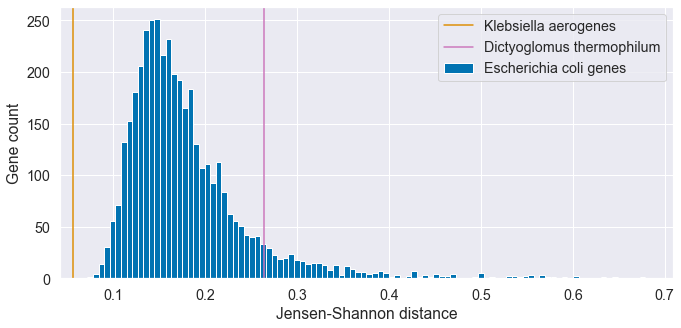

In [13]:
e_coli_genes_df, e_coli_distances = load_gene_dist(e_coli_assembly)

f, ax = plt.subplots(1, 1, figsize=(11, 5))
ax.hist(e_coli_distances, bins=100, label='Escherichia coli genes');
ax.axvline(klebsiella_aerogenes_distance, color=palette[1], label='Klebsiella aerogenes');
ax.axvline(dictyoglomus_thermophilum_distance, color=palette[4], label='Dictyoglomus thermophilum');
ax.legend();
ax.set_xlabel('Jensen-Shannon distance');
ax.set_ylabel('Gene count');
#f.savefig(
#    os.path.join(os.getcwd(), 'report/diagrams/e_coli_distances.eps'), 
#    bbox_inches='tight', 
#    dpi=300,
#)

In [14]:
e_coli_genes_df_ix = e_coli_genes_df.set_index('protein_id', drop=True)
e_coli_genes_df_ix.head()

,distance
protein_id,
AIZ54182.1,0.580067
AIZ50783.1,0.108037
AIZ51761.1,0.135182
AIZ52710.1,0.118310
AIZ53685.1,0.232425


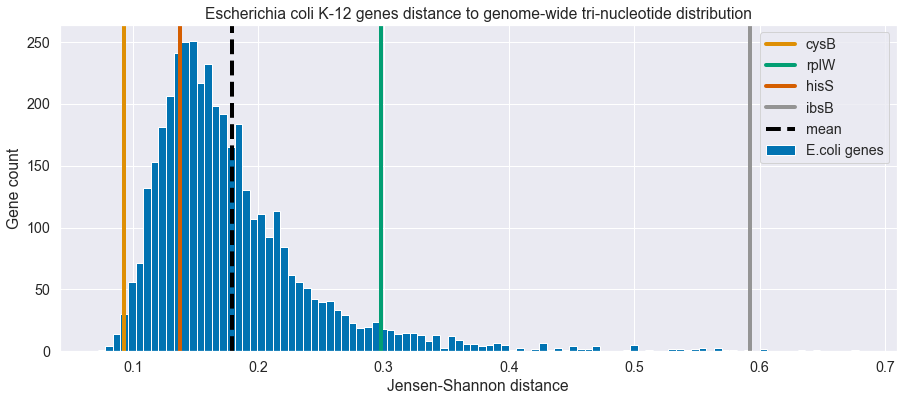

In [15]:
f, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.hist(e_coli_distances, bins=100, label='E.coli genes');


ax.axvline(e_coli_genes_df_ix.loc['AIZ51075.1']['distance'], color=palette[1], label='cysB', linewidth=4);
ax.axvline(e_coli_genes_df_ix.loc['AIZ53102.1']['distance'], color=palette[2], label='rplW', linewidth=4);
ax.axvline(e_coli_genes_df_ix.loc['AIZ52331.1']['distance'], color=palette[3], label='hisS', linewidth=4);
ax.axvline(e_coli_genes_df_ix.loc['AIZ54285.1']['distance'], color=palette[7], label='ibsB', linewidth=4);

mean = np.mean(e_coli_distances)
ax.axvline(mean, color='black', label='mean', linewidth=4, linestyle='--');

ax.legend();
ax.set_title('Escherichia coli K-12 genes distance to genome-wide tri-nucleotide distribution');
ax.set_xlabel('Jensen-Shannon distance');
ax.set_ylabel('Gene count');

In [16]:
e_coli_assembly

'GCA_000800765.1'

In [17]:
e_coli_pfam = load_protein_families(e_coli_assembly, 'pfam')
e_coli_pfam.head()

,assembly_accession,protein_id,query_id,label
query,,,,
MreC,GCA_000800765.1,AIZ53040.1,PF04085.14,cell-wall-structural-complex-MreBCD-transmembr...
MreD,GCA_000800765.1,AIZ53039.1,PF04093.12,cell-wall-structural-complex-MreBCD-transmembr...
MR_MLE_C,GCA_000800765.1,AIZ53504.1,PF13378.6,galactonate-dehydratase
MR_MLE_C,GCA_000800765.1,AIZ51372.1,PF13378.6,bifunctional-D-altronate/D-mannonate-dehydratase
MR_MLE_C,GCA_000800765.1,AIZ52590.1,PF13378.6,"glucarate-dehydratase-related-protein,-substra..."


In [18]:
len(e_coli_pfam.loc['Anticodon_1'])

3

## Sample accession and plot

In [19]:
def sample_assemblies(assemblies, n_samples, seed=None):
    rs = np.random.RandomState(seed)
    return rs.choice(assemblies, replace=False, size=n_samples)

In [20]:
def plot_domain_distances(
    assembly_df, 
    domain_query, 
    query_type,
    n_samples, 
    tail='left',
    phylum=None,
    n_cols=3, 
    seed=None,
    figsize=(16, 5),
):
    n_cols = np.amin([n_cols, n_samples])
    n_rows = int(np.ceil(n_samples / n_cols))
    
    f, axes_ = plt.subplots(n_rows, n_cols, figsize=(figsize[0], figsize[1] * n_rows))
    
    if n_samples == 1:
        axes = np.array([axes_])
    else:
        axes = axes_.flatten()
        
    n_axes = len(axes)
    
    if phylum is not None:
        assemblies = assembly_df[assembly_df['phylum'] == phylum].index
    else:
        assemblies = assembly_df.index
    
    sampled_assemblies = sample_assemblies(assemblies, n_samples, seed)
    
    for i, assembly in enumerate(sampled_assemblies):
        ax = axes[i]
        if (i+1) > n_axes:
            ax.remove()
            continue
            
        gene_dist_path = os.path.join(
            os.getcwd(),
            f'data/sequences/{assembly}/{assembly}_tri_nucleotide_distance_to_mean.csv',
        )
        gene_dist = pd.read_csv(gene_dist_path)
            
        if query_type == 'pfam':
            source_path = os.path.join(
                os.getcwd(),
                f'data/sequences/{assembly}/{assembly}_pfam.csv.gz',
            )
        else:
            source_path = os.path.join(
                os.getcwd(),
                f'data/sequences/{assembly}/{assembly}_tigr.csv.gz',
            )
            
        domain_source = pd.read_csv(source_path)
        
        protein_ids = domain_source[domain_source['query'] == domain_query]['protein_id'].values

        distances = gene_dist['distance'].values
        ax.hist(distances, bins=100, alpha=1, label='genes');

        mean = np.mean(distances)
        ax.axvline(mean, color=palette[4], alpha=1, label='genes mean', linewidth=3)

        for j, v in enumerate(gene_dist[gene_dist['protein_id'].isin(protein_ids)]['distance'].values):
            if tail == 'left':
                color = 'green' if v < mean else 'red'
            else:
                color = 'green' if v > mean else 'red'
                
            label = None
            if j == 0:
                label = domain_query
                
            ax.axvline(v, color=palette[1], alpha=1, label=label);
            
        if i == 0:
            ax.legend()
            
        ax.set_title(assembly)
        
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        
    return f

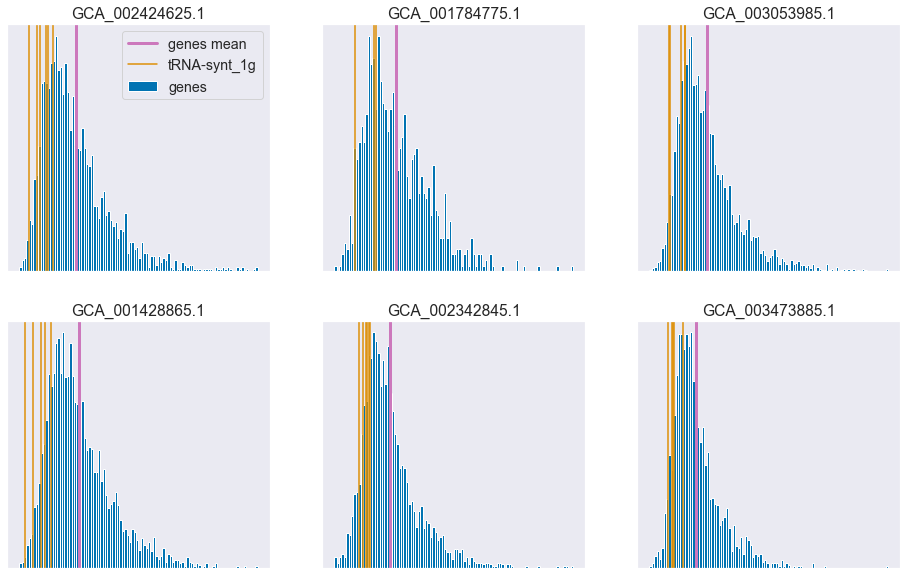

In [166]:
f = plot_domain_distances(
    assembly_df, 
    domain_query='tRNA-synt_1g', 
    query_type='pfam', 
    n_samples=6, 
    #phylum='Firmicutes',
    seed=99,
)
#f.savefig(
#    os.path.join(os.getcwd(), 'report/diagrams/trna_synt_1g_dist.eps'), 
#    bbox_inches='tight', 
#    dpi=300,
#)

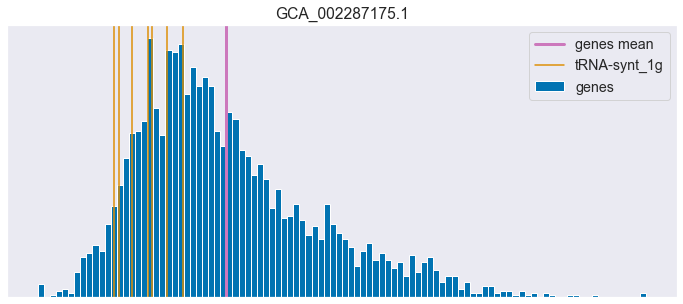

In [22]:
f = plot_domain_distances(
    assembly_df.loc[['GCA_002287175.1']],
    domain_query='tRNA-synt_1g', 
    query_type='pfam', 
    n_samples=1, 
    figsize=(12, 5),
)

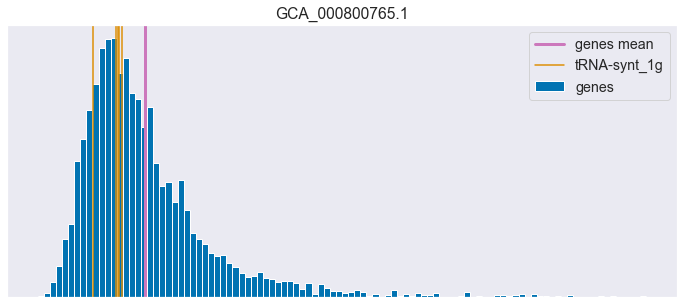

In [23]:
f = plot_domain_distances(
    assembly_df.loc[[e_coli_assembly]], 
    domain_query='tRNA-synt_1g', 
    query_type='pfam', 
    n_samples=1, 
    figsize=(12, 5),
)

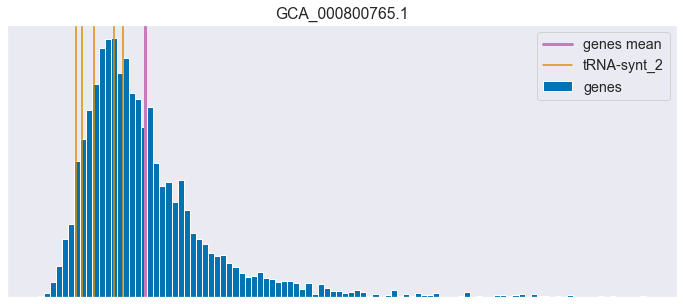

In [24]:
f = plot_domain_distances(
    assembly_df.loc[[e_coli_assembly]], 
    domain_query='tRNA-synt_2', 
    query_type='pfam', 
    n_samples=1, 
    figsize=(12, 5),
)

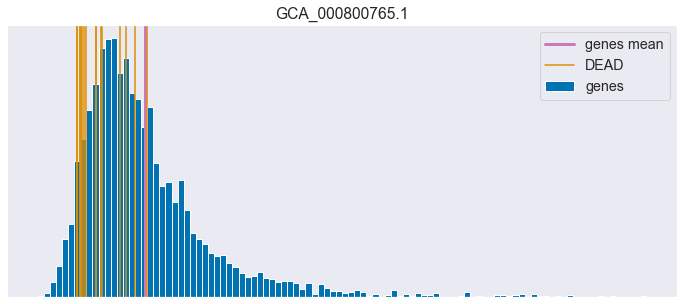

In [25]:
f = plot_domain_distances(
    assembly_df.loc[[e_coli_assembly]], 
    domain_query='DEAD', 
    query_type='pfam', 
    n_samples=1, 
    figsize=(12, 5),
)

In [26]:
e_coli_genes_df[
    e_coli_genes_df['protein_id'].isin(e_coli_pfam.loc['CSD']['protein_id'].values)
].sort_values('distance').head()

,protein_id,distance
814,AIZ54729.1,0.216307
923,AIZ50799.1,0.223888
1449,AIZ51356.1,0.230046
924,AIZ50800.1,0.257119
579,AIZ54473.1,0.289975


In [27]:
e_coli_genes_df.sort_values('distance').head()

,protein_id,distance
1699,AIZ51623.1,0.071756
2318,AIZ52281.1,0.079249
3035,AIZ53042.1,0.080830
3846,AIZ53923.1,0.082732
3710,AIZ53770.1,0.083649


In [28]:
e_coli_genes_df[e_coli_genes_df['protein_id'] == 'AIZ53054.1']

,protein_id,distance
3048,AIZ53054.1,0.089955


In [29]:
e_coli_pfam[e_coli_pfam['protein_id'] == 'AIZ53175.1']

,assembly_accession,protein_id,query_id,label
query,,,,
tRNA-synt_1b,GCA_000800765.1,AIZ53175.1,PF00579.25,tryptophanyl-tRNA-synthetase


In [30]:
#anticodon_protein_ids = e_coli_pfam.loc[
#    ['HGTP_anticodon', 'Anticodon_1', 'DALR_1', 'DALR_2', 'FDX-ACB', 'tRNA_bind', 'tRNA_anti-codon']
#]['protein_id'].unique()
anticodon_protein_ids = e_coli_pfam[
    e_coli_pfam['label'].notnull() & 
    (e_coli_pfam['label'].str.contains('tRNA')) &
    (e_coli_pfam['label'].str.contains('synthetase'))
]['protein_id'].unique()
anticodon_protein_ids

array(['AIZ51516.1', 'AIZ51434.1', 'AIZ54744.1', 'AIZ51520.1',
       'AIZ51663.1', 'AIZ51762.1', 'AIZ54080.1', 'AIZ54492.1',
       'AIZ51924.1', 'AIZ54375.1', 'AIZ53175.1', 'AIZ54523.1',
       'AIZ52218.1', 'AIZ51182.1', 'AIZ51693.1', 'AIZ51682.1',
       'AIZ53946.1', 'AIZ52687.1', 'AIZ54785.1', 'AIZ51730.1',
       'AIZ52331.1', 'AIZ52494.1', 'AIZ53364.1', 'AIZ51515.1',
       'AIZ53363.1'], dtype=object)

In [110]:
anticodon_protein_ids

array(['AIZ51516.1', 'AIZ51434.1', 'AIZ54744.1', 'AIZ51520.1',
       'AIZ51663.1', 'AIZ51762.1', 'AIZ54080.1', 'AIZ54492.1',
       'AIZ51924.1', 'AIZ54375.1', 'AIZ53175.1', 'AIZ54523.1',
       'AIZ52218.1', 'AIZ51182.1', 'AIZ51693.1', 'AIZ51682.1',
       'AIZ53946.1', 'AIZ52687.1', 'AIZ54785.1', 'AIZ51730.1',
       'AIZ52331.1', 'AIZ52494.1', 'AIZ53364.1', 'AIZ51515.1',
       'AIZ53363.1'], dtype=object)

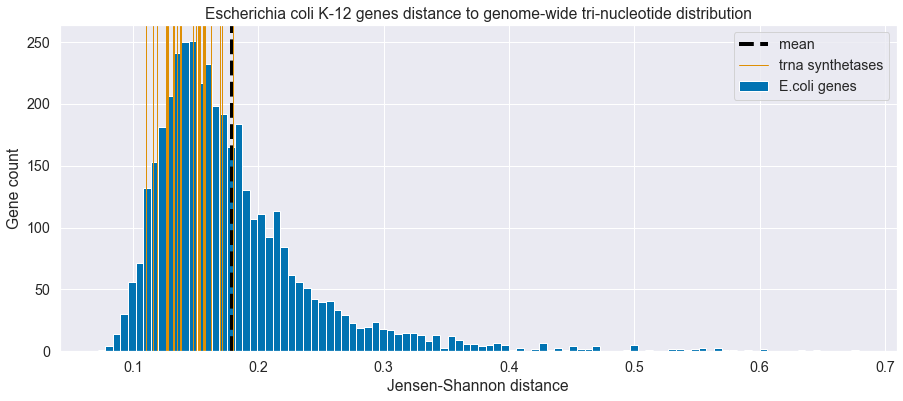

In [31]:
f, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.hist(e_coli_distances, bins=100, label='E.coli genes');

mean = np.mean(e_coli_distances)
ax.axvline(mean, color='black', label='mean', linewidth=4, linestyle='--');

protein_id_distances = []
over_the_mean = []
for i, protein_id in enumerate(anticodon_protein_ids):
    label = 'trna synthetases' if i == 0 else None
    distance = e_coli_genes_df_ix.loc[protein_id]['distance']
    ax.axvline(distance, color=palette[1], linewidth=1, label=label);
    
    protein_id_distances.append((protein_id, distance))
    
    if distance > mean:
        over_the_mean.append(protein_id)

ax.legend();
ax.set_title('Escherichia coli K-12 genes distance to genome-wide tri-nucleotide distribution');
ax.set_xlabel('Jensen-Shannon distance');
ax.set_ylabel('Gene count');

In [32]:
sorted(protein_id_distances, key=lambda t: t[1])[:10]

[('AIZ53946.1', 0.110295),
 ('AIZ51520.1', 0.11606400000000001),
 ('AIZ51182.1', 0.119198),
 ('AIZ53175.1', 0.12623800000000002),
 ('AIZ51924.1', 0.12700999999999998),
 ('AIZ52494.1', 0.12754100000000002),
 ('AIZ54785.1', 0.12820399999999998),
 ('AIZ54523.1', 0.13153399999999998),
 ('AIZ51516.1', 0.133043),
 ('AIZ51434.1', 0.13500299999999998)]

In [33]:
over_the_mean

['AIZ53364.1']

In [34]:
e_coli_pfam[e_coli_pfam['protein_id'] == 'AIZ53363.1']

,assembly_accession,protein_id,query_id,label
query,,,,
tRNA_synt_2f,GCA_000800765.1,AIZ53363.1,PF02092.17,"glycine-tRNA-synthetase,-beta-subunit"
DALR_1,GCA_000800765.1,AIZ53363.1,PF05746.15,"glycine-tRNA-synthetase,-beta-subunit"


In [35]:
e_coli_pfam[e_coli_pfam['protein_id'].isin(over_the_mean)]

,assembly_accession,protein_id,query_id,label
query,,,,
tRNA-synt_2e,GCA_000800765.1,AIZ53364.1,PF02091.15,"glycine-tRNA-synthetase,-alpha-subunit"


In [36]:
e_coli_pfam.loc['tRNA-synt_1g']

,assembly_accession,protein_id,query_id,label
query,,,,
tRNA-synt_1g,GCA_000800765.1,AIZ51924.1,PF09334.11,methionyl-tRNA-synthetase
tRNA-synt_1g,GCA_000800765.1,AIZ54492.1,PF09334.11,leucyl-tRNA-synthetase
tRNA-synt_1g,GCA_000800765.1,AIZ51762.1,PF09334.11,isoleucyl-tRNA-synthetase
tRNA-synt_1g,GCA_000800765.1,AIZ54080.1,PF09334.11,valyl-tRNA-synthetase
tRNA-synt_1g,GCA_000800765.1,AIZ54375.1,PF09334.11,cysteinyl-tRNA-synthetase


In [37]:
dictyoglomus_thermophilum_genes_df[
    dictyoglomus_thermophilum_genes_df['protein_id'].isin(
        dictyoglomus_thermophilum_pfam.loc['HD']['protein_id'].values
    )
].sort_values('distance').head()

,protein_id,distance
609,ACI19392.1,0.122477
77,ACI18823.1,0.125280
1568,ACI19615.1,0.134023
177,ACI19358.1,0.136021
1507,ACI18546.1,0.139765


In [38]:
e_coli_pfam.loc[['HTH_1']]['protein_id'].unique()

array(['AIZ53162.1', 'AIZ52355.1', 'AIZ52224.1', 'AIZ51388.1',
       'AIZ52610.1', 'AIZ52219.1', 'AIZ51804.1', 'AIZ53580.1',
       'AIZ53771.1', 'AIZ51855.1', 'AIZ53572.1', 'AIZ54606.1',
       'AIZ52182.1', 'AIZ51147.1', 'AIZ51456.1', 'AIZ51135.1',
       'AIZ54355.1', 'AIZ53033.1', 'AIZ54751.1', 'AIZ51222.1',
       'AIZ52338.1', 'AIZ54452.1', 'AIZ52915.1', 'AIZ52715.1',
       'AIZ54546.1', 'AIZ53319.1', 'AIZ52107.1', 'AIZ51323.1',
       'AIZ52930.1', 'AIZ52643.1', 'AIZ52901.1', 'AIZ51608.1',
       'AIZ52397.1', 'AIZ54189.1', 'AIZ51357.1', 'AIZ52853.1',
       'AIZ51965.1', 'AIZ51075.1', 'AIZ54478.1', 'AIZ52719.1',
       'AIZ54598.1', 'AIZ53523.1', 'AIZ51826.1', 'AIZ51793.1',
       'AIZ51803.1', 'AIZ53393.1'], dtype=object)

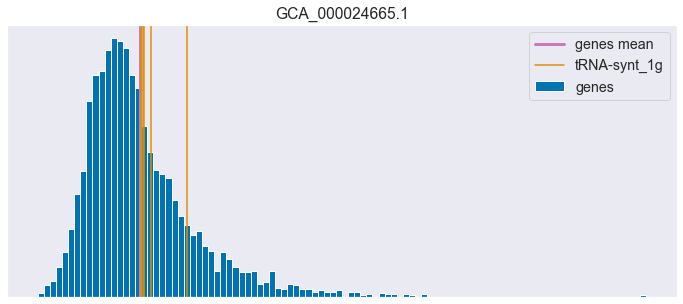

In [39]:
f = plot_domain_distances(
    assembly_df.loc[['GCA_000024665.1']], 
    domain_query='tRNA-synt_1g', 
    query_type='pfam', 
    n_samples=1, 
    figsize=(12, 5),
)

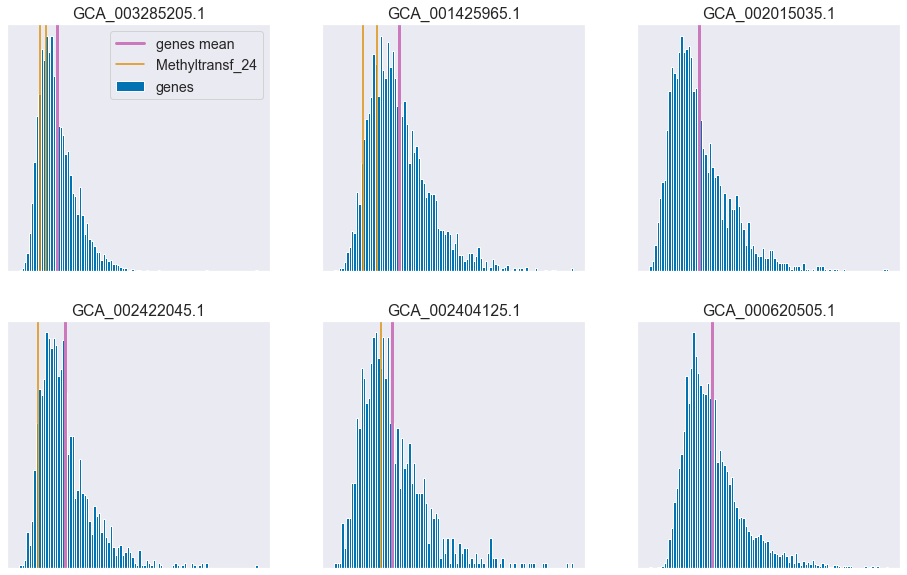

In [40]:
f = plot_domain_distances(
    assembly_df, 
    domain_query='Methyltransf_24', 
    query_type='pfam', 
    n_samples=6, 
    #phylum='Fibrobacteres',
    seed=444,
)
#f.savefig(
#    os.path.join(os.getcwd(), 'report/diagrams/methyltransf_24_dist.eps'), 
#    bbox_inches='tight', 
#    dpi=300,
#)

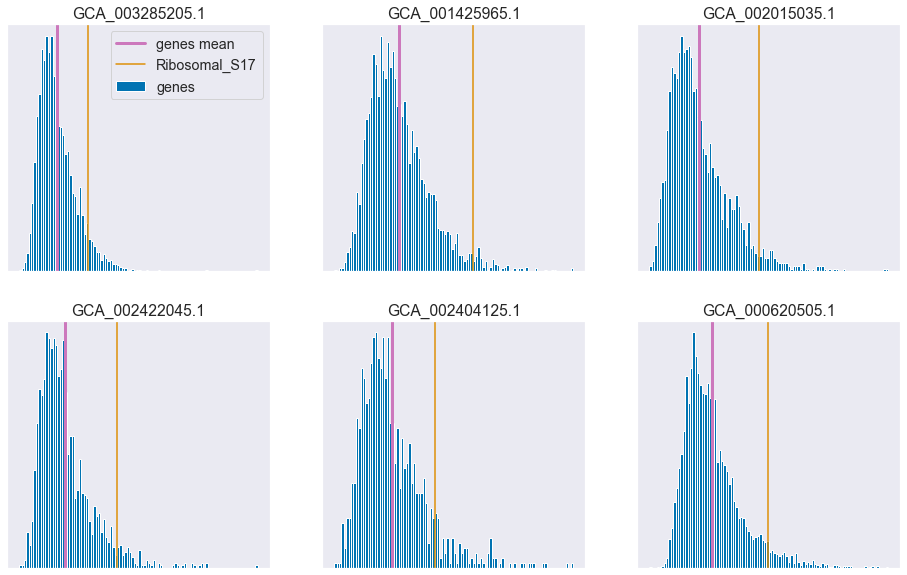

In [41]:
f = plot_domain_distances(
    assembly_df, 
    domain_query='Ribosomal_S17', 
    query_type='pfam', 
    tail='right',
    n_samples=6, 
    seed=444,
)
#f.savefig(
#    os.path.join(os.getcwd(), 'report/diagrams/ribosomal_s17.eps'), 
#    bbox_inches='tight', 
#    dpi=300,
#)

## Evidence count

In [263]:
def load_phylum_evidence(phylum, query_type, tail):
    phylum_p = phylum.lower().replace(' ', '_')
            
    path = os.path.join(
        os.getcwd(),
        f'data/phylum/{phylum_p}/{phylum_p}_{query_type}_probability_{tail}.csv',
    )
    if not os.path.isfile(path):
        return None

    return pd.read_csv(path, index_col='query' if query_type == 'pfam' else 'id')


def compute_phylum_evidence_count(assembly_df, query, query_type, tail, print_negative=False, print_weak=False):
    counts = collections.defaultdict(int)
    phyla = assembly_df['phylum'].unique()
    for i, phylum in enumerate(phyla):
        if pd.isnull(phylum):
            continue
            
        df = load_phylum_evidence(phylum, query_type, tail)
        if df is None:
            continue
        try:
            evidence = df.loc[query]['evidence_strength']
            
            if print_negative and evidence == 'Negative':
                print(phylum)
            elif print_weak and evidence == 'Weak':
                print(phylum)
            
            counts[evidence] += 1
        except KeyError:
            continue
            
    return dict(counts)

In [264]:
compute_phylum_evidence_count(assembly_df, 'tRNA-synt_1g', 'pfam', 'left')

{'Decisive': 54, 'Very Strong': 11, 'Strong': 3}

In [44]:
compute_phylum_evidence_count(assembly_df, 'tRNA-synt_1g', 'pfam', 'right')

{'Negative': 68}

In [45]:
compute_phylum_evidence_count(assembly_df, 'tRNA-synt_1', 'pfam', 'left')

{'Decisive': 49, 'Strong': 9, 'Very Strong': 10}

In [46]:
compute_phylum_evidence_count(assembly_df, 'tRNA-synt_1', 'pfam', 'right')

{'Negative': 68}

In [47]:
compute_phylum_evidence_count(assembly_df, 'Helicase_C', 'pfam', 'left')

{'Decisive': 62, 'Strong': 2, 'Substantial': 1, 'Very Strong': 3}

In [48]:
compute_phylum_evidence_count(assembly_df, 'Helicase_C', 'pfam', 'right')

{'Negative': 68}

In [245]:
def compute_assembly_evidence_count(assembly_df, query, query_type, tail, phylum):
    counts = collections.defaultdict(int)
    
    accessions = assembly_df[assembly_df['phylum'] == phylum].index
        
    for i, accession in enumerate(accessions): 
        path = os.path.join(
            os.getcwd(),
            f'data/sequences/{accession}/{accession}_{query_type}_probability_{tail}.csv',
        )
        if not os.path.isfile(path):
            continue
            
        df = pd.read_csv(path, index_col='query' if query_type == 'pfam' else 'id')
        try:
            evidence = df.loc[query]['evidence_strength']
            counts[evidence] += 1
        except KeyError:
            continue
            
    return dict(counts)

In [50]:
compute_assembly_evidence_count(assembly_df, 'tRNA-synt_1g', 'pfam', 'left', 'Fibrobacteres')

{'Negative': 14, 'Weak': 25}

In [51]:
compute_assembly_evidence_count(assembly_df, 'tRNA-synt_1g', 'pfam', 'right', 'Fibrobacteres')

{'Weak': 13, 'Negative': 26}

In [52]:
compute_assembly_evidence_count(assembly_df, 'tRNA-synt_1', 'pfam', 'left', 'Fibrobacteres')

{'Weak': 23, 'Negative': 15}

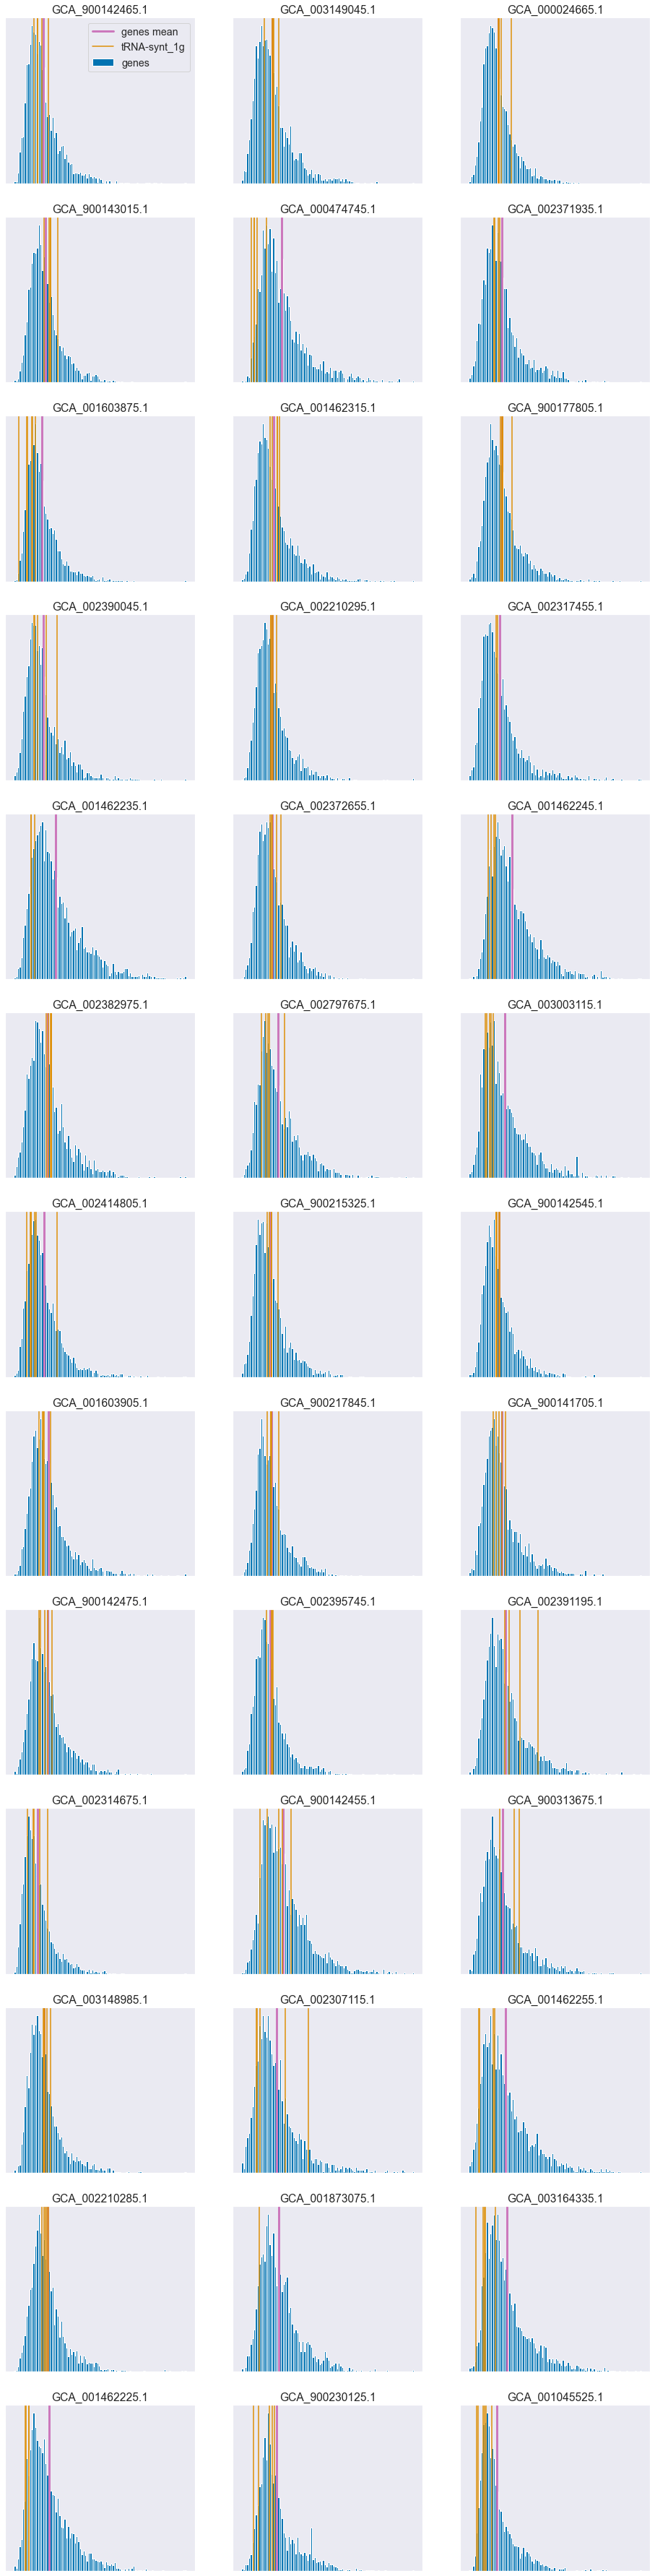

In [53]:
f = plot_domain_distances(
    assembly_df, 
    domain_query='tRNA-synt_1g', 
    query_type='pfam', 
    n_samples=39, 
    phylum='Fibrobacteres',
    seed=444,
)

## Distribution of log evidence 

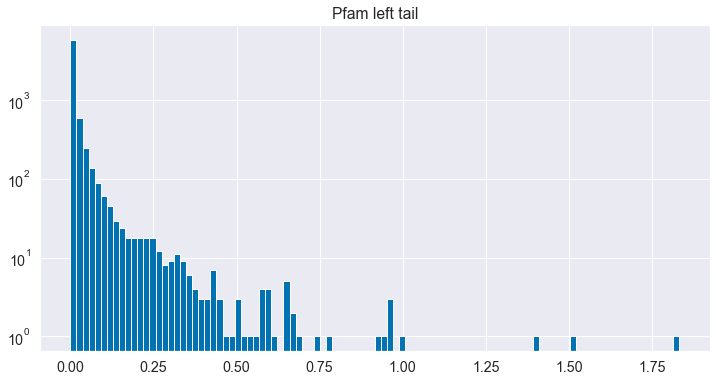

In [54]:
pfam_left_df = pd.read_csv(os.path.join(os.getcwd(), 'data/pfam_probability_left.csv'))
f, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist([v for v in pfam_left_df['evidence'] if v > 0], bins=100, log=True);
ax.set_title('Pfam left tail');

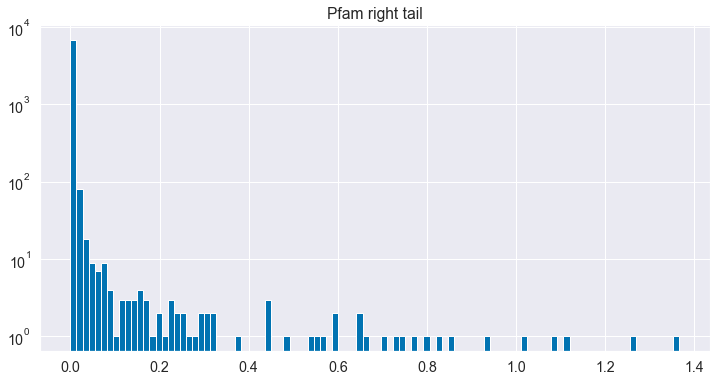

In [55]:
pfam_right_df = pd.read_csv(os.path.join(os.getcwd(), 'data/pfam_probability_right.csv'))
f, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist([v for v in pfam_right_df['evidence'] if v > 0], bins=100, log=True);
ax.set_title('Pfam right tail');

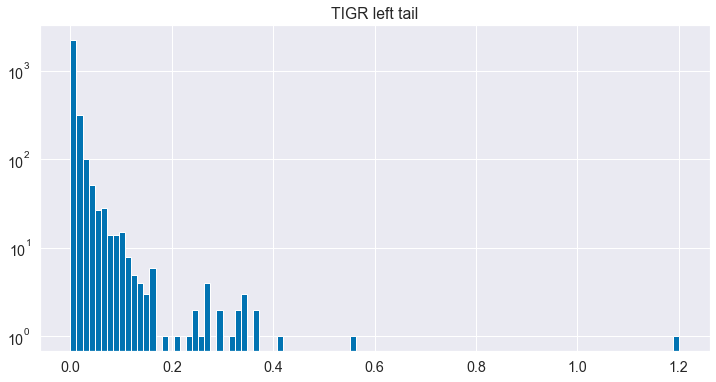

In [56]:
tigr_left_df = pd.read_csv(os.path.join(os.getcwd(), 'data/tigr_probability_left.csv'))
f, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist([v for v in tigr_left_df['evidence'] if v > 0], bins=100, log=True);
ax.set_title('TIGR left tail');

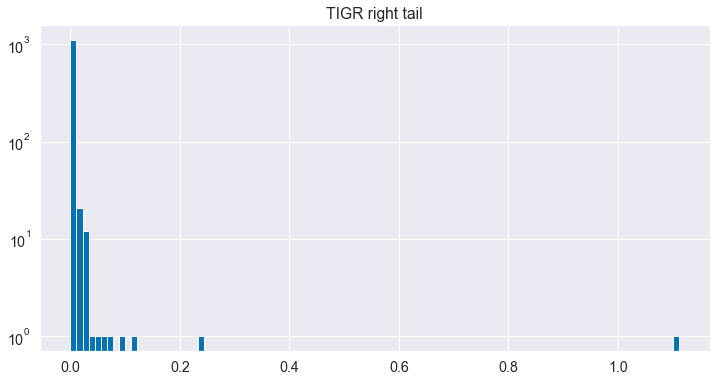

In [57]:
tigr_right_df = pd.read_csv(os.path.join(os.getcwd(), 'data/tigr_probability_right.csv'))
f, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist([v for v in tigr_right_df['evidence'] if v > 0], bins=100, log=True);
ax.set_title('TIGR right tail');

## Ribsomal proteins

In [58]:
complete_genome_df = assembly_df[
    assembly_df['phylum'].notnull() & 
    (assembly_df['assembly_level'] == 'Complete Genome')
]
main_strains = complete_genome_df.index
len(main_strains)

2584

In [59]:
main_phyla = complete_genome_df['phylum'].unique()
len(main_phyla)

53

In [60]:
rs = np.random.RandomState(444)
main_strains_sample = []
for phylum in main_phyla:
    s = complete_genome_df[complete_genome_df['phylum'] == phylum].index
    main_strains_sample.append(rs.choice(s, size=1, replace=False)[0])

In [61]:
def ribsomal_distance_vs_ecoli(sampled_assemblies, domain_query, query_type):
    e_coli_genes_df, e_coli_distances = load_gene_dist(e_coli_assembly)

    f, ax = plt.subplots(1, 1, figsize=(11, 5))
    ax.hist(e_coli_distances, bins=100, label='Escherichia coli genes');
    
    start = True
    for i, assembly in enumerate(sampled_assemblies):
        gene_dist_path = os.path.join(
            os.getcwd(),
            f'data/sequences/{assembly}/{assembly}_tri_nucleotide_distance_to_mean.csv',
        )
        gene_dist = pd.read_csv(gene_dist_path)
            
        if query_type == 'pfam':
            source_path = os.path.join(
                os.getcwd(),
                f'data/sequences/{assembly}/{assembly}_pfam.csv.gz',
            )
        else:
            source_path = os.path.join(
                os.getcwd(),
                f'data/sequences/{assembly}/{assembly}_tigr.csv.gz',
            )
            
        domain_source = pd.read_csv(source_path)
        
        protein_ids = domain_source[domain_source['query'] == domain_query]['protein_id'].values

        values = gene_dist[gene_dist['protein_id'].isin(protein_ids)]['distance'].values
        
        if len(values) == 0:
            continue
        
        mean_dist = np.mean(values)
        
        label = None
        if start:
            label = f'{domain_query} mean distance'
            start = False
        
        ax.axvline(mean_dist, color=palette[1], alpha=.7, label=label)
    
    ax.legend();
    ax.set_xlabel('Jensen-Shannon distance');
    ax.set_ylabel('Gene count');
    return f, ax

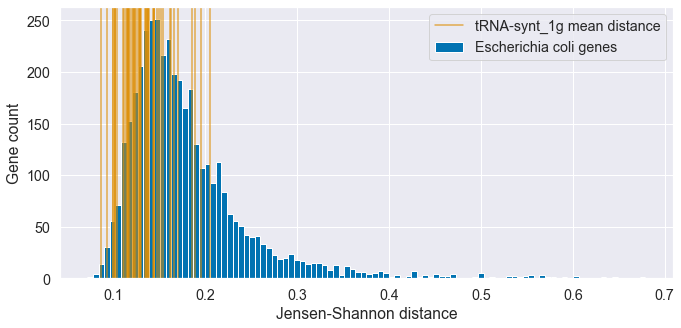

In [62]:
ribsomal_distance_vs_ecoli(main_strains_sample, 'tRNA-synt_1g', 'pfam');

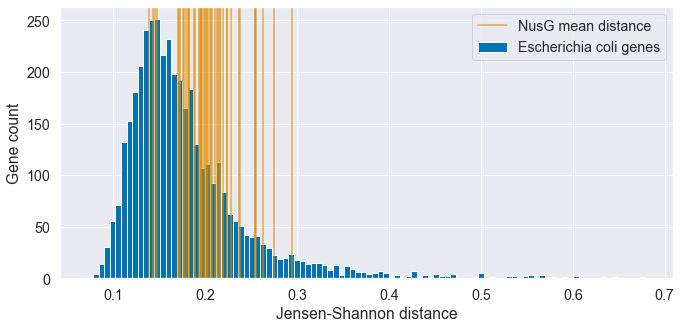

In [63]:
ribsomal_distance_vs_ecoli(main_strains_sample, 'NusG', 'pfam');

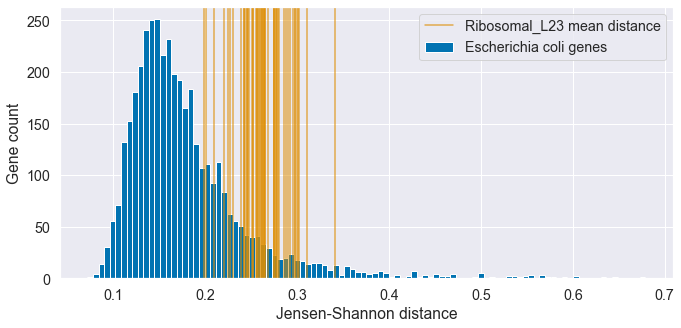

In [64]:
ribsomal_distance_vs_ecoli(main_strains_sample, 'Ribosomal_L23', 'pfam');

## Jensen-Shannon distance vs tAI

In [65]:
def make_map_protein_id_to_gene(assembly):
    protein_id_to_gene = {}
    gene_to_protein_id = {}
    
    match_re_1 = r'.*gene=([^;]+).*protein_id=([^;]+).*$'
    match_re_2 = r'.*protein_id=([^;]+).*gene=([^;]+).*$'

    path = os.path.join(os.getcwd(), f'data/sequences/{assembly}/{assembly}_genomic.gff.gz')
    with gzip.open(path) as f:
        for line in f:
            l = str(line)

            m1 = re.match(match_re_1, l)
            if m1 is not None:
                protein_id_to_gene[m1[2]] = m1[1]
                gene_to_protein_id[m1[1]] = m1[2]
                continue

            m2 = re.match(match_re_2, l)
            if m2 is not None:
                protein_id_to_gene[m2[1]] = m2[2]
                gene_to_protein_id[m2[2]] = m2[1]
                continue
                
    return protein_id_to_gene, gene_to_protein_id

In [66]:
protein_id_to_gene, gene_to_protein_id = make_map_protein_id_to_gene(e_coli_assembly)
len(protein_id_to_gene)

4034

In [67]:
path = os.path.join(os.getcwd(), 'data/raw_tai/Escherichia coli BCT str. K-12 substr..csv')
e_coli_tai = pd.read_csv(path, index_col='Gene')
e_coli_tai.head()

,Unnamed: 0,tAI
Gene,,
aaaD,1,0.214270
aaaE,2,0.221321
aaeA,3,0.226306
aaeB,4,0.208433
aaeR,5,0.212711


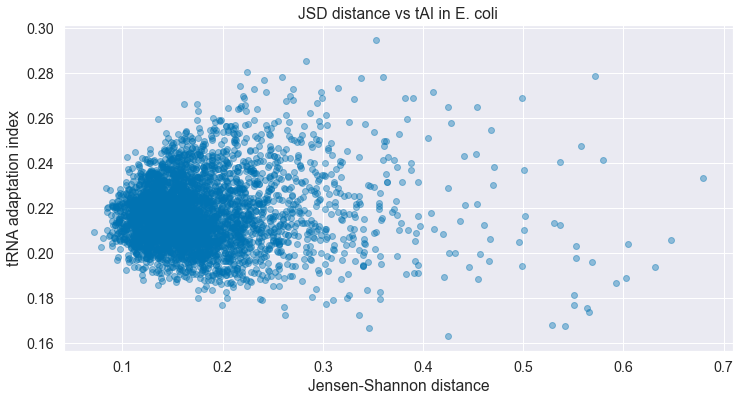

In [68]:
f, ax = plt.subplots(1, 1, figsize=(12, 6))

x, y = [], []
for gene in e_coli_tai.index:
    if gene in gene_to_protein_id:
        tAI = e_coli_tai.loc[gene]['tAI']
        
        df_ = e_coli_genes_df[e_coli_genes_df['protein_id'] == gene_to_protein_id[gene]]
        if len(df_) > 0:
            x.append(df_.iloc[0]['distance'])
            y.append(tAI)
        
ax.scatter(x, y, alpha=0.4);
ax.set_xlabel('Jensen-Shannon distance');
ax.set_ylabel('tRNA adaptation index');
ax.set_title('JSD distance vs tAI in E. coli');

In [69]:
gene_to_protein_id['acrF']

'AIZ53054.1'

## Interpret from TIGR down to Pfam

In [70]:
e_coli_tigr = load_protein_families(e_coli_assembly, 'tigr')
e_coli_tigr.head()

,assembly_accession,protein_id,query_id,label
query,,,,
TIGR00001,GCA_000800765.1,AIZ51518.1,TIGR00001,50S-ribosomal-subunit-protein-L35
TIGR00002,GCA_000800765.1,AIZ52426.1,TIGR00002,30S-ribosomal-subunit-protein-S16
TIGR00004,GCA_000800765.1,AIZ52909.1,TIGR00004,putative-reactive-intermediate-deaminase
TIGR00004,GCA_000800765.1,AIZ54065.1,TIGR00004,"conserved-protein,-UPF0131-family"
TIGR00005,GCA_000800765.1,AIZ52412.1,TIGR00005,"23S-rRNA-pseudouridine(1911,1915,1917)-synthase"


In [106]:
e_coli_pfam_res = load_assembly_bias_results(e_coli_assembly, 'pfam', 'left')
e_coli_pfam_res.head()

,id,description,log_probability,log_probability_random,n_elements,evidence,evidence_strength,rank
query,,,,,,,,
HTH_1,PF00126,Bacterial regulatory helix-turn-helix protein;...,-13.815231,-18.140530,92,1.878453,Very Strong,1
HATPase_c,PF02518,Histidine kinase-; DNA gyrase B-; and HSP90-li...,-8.703033,-12.619499,64,1.700899,Very Strong,2
ABC_tran,PF00005,ABC transporter,-11.840908,-14.788475,75,1.280112,Strong,3
LysR_substrate,PF03466,LysR substrate binding domain,-6.376242,-8.675906,44,0.998731,Substantial,4
HisKA,PF00512,His Kinase A (phospho-acceptor) domain,-5.215546,-7.492828,38,0.989011,Substantial,5


In [84]:
e_coli_res = load_assembly_bias_results(e_coli_assembly, 'tigr', 'left')
e_coli_res.head()

,query,description,log_probability,log_probability_random,n_elements,evidence,evidence_strength,rank
id,,,,,,,,
TIGR00254,GGDEF,diguanylate cyclase (GGDEF) domain,-2.248013,-3.154875,16,0.393845,Weak,1
TIGR01189,ccmA,heme ABC exporter; ATP-binding protein CcmA,-1.597849,-2.168976,11,0.248037,Weak,2
TIGR00229,sensory_box,PAS domain S-box protein,-0.818237,-1.380258,7,0.244083,Weak,3
TIGR01730,RND_mfp,efflux transporter; RND family; MFP subunit,-1.841201,-2.366156,12,0.227985,Weak,4
TIGR01409,TAT_signal_seq,Tat (twin-arginine translocation) pathway sign...,-1.659131,-2.168976,11,0.221423,Weak,5


In [86]:
tigr_fam = load_protein_families(e_coli_assembly, 'tigr')
tigr_fam.head()

,assembly_accession,protein_id,query_id,label
query,,,,
TIGR00001,GCA_000800765.1,AIZ51518.1,TIGR00001,50S-ribosomal-subunit-protein-L35
TIGR00002,GCA_000800765.1,AIZ52426.1,TIGR00002,30S-ribosomal-subunit-protein-S16
TIGR00004,GCA_000800765.1,AIZ52909.1,TIGR00004,putative-reactive-intermediate-deaminase
TIGR00004,GCA_000800765.1,AIZ54065.1,TIGR00004,"conserved-protein,-UPF0131-family"
TIGR00005,GCA_000800765.1,AIZ52412.1,TIGR00005,"23S-rRNA-pseudouridine(1911,1915,1917)-synthase"


In [124]:
trna_synth = e_coli_res[e_coli_res['description'].str.contains('--tRNA ligase')]
trna_synth.sort_values('evidence', ascending=False)

,query,description,log_probability,log_probability_random,n_elements,evidence,evidence_strength,rank
id,,,,,,,,
TIGR00499,lysS_bact,lysine--tRNA ligase,-0.277223,-0.394359,2,0.050872,Weak,49
TIGR00418,thrS,threonine--tRNA ligase,-0.123371,-0.197180,1,0.032055,Weak,198
TIGR00233,trpS,tryptophan--tRNA ligase,-0.134947,-0.197180,1,0.027027,Weak,310
TIGR00398,metG,methionine--tRNA ligase,-0.135831,-0.197180,1,0.026643,Weak,322
TIGR00399,metG_C_term,methionine--tRNA ligase; beta subunit,-0.135831,-0.197180,1,0.026643,Weak,323
TIGR00344,alaS,alanine--tRNA ligase,-0.136440,-0.197180,1,0.026379,Weak,332
TIGR00457,asnS,asparagine--tRNA ligase,-0.137200,-0.197180,1,0.026049,Weak,342
TIGR00440,glnS,glutamine--tRNA ligase,-0.141027,-0.197180,1,0.024387,Weak,396
TIGR00468,pheS,phenylalanine--tRNA ligase; alpha subunit,-0.142766,-0.197180,1,0.023632,Weak,423


In [126]:
tnra_synth_proteins = tigr_fam.loc[trna_synth.index]['protein_id'].unique()
tnra_synth_proteins

array(['AIZ53946.1', 'AIZ52687.1', 'AIZ51520.1', 'AIZ53175.1',
       'AIZ51924.1', 'AIZ52494.1', 'AIZ54785.1', 'AIZ54523.1',
       'AIZ51516.1', 'AIZ51434.1', 'AIZ52331.1', 'AIZ52218.1',
       'AIZ51762.1', 'AIZ51693.1', 'AIZ54080.1', 'AIZ51515.1',
       'AIZ54492.1', 'AIZ54375.1', 'AIZ51682.1', 'AIZ54744.1',
       'AIZ51730.1', 'AIZ53363.1', 'AIZ53364.1'], dtype=object)

In [133]:
tnra_synth_domains = np.unique(e_coli_pfam[e_coli_pfam['protein_id'].isin(tnra_synth_proteins)].index.tolist())
tnra_synth_domains

array(['Anticodon_1', 'Arg_tRNA_synt_N', 'B3_4', 'B5', 'DALR_1', 'DALR_2',
       'DHHA1', 'FDX-ACB', 'GAD', 'HGTP_anticodon', 'Phe_tRNA-synt_N',
       'S4', 'Seryl_tRNA_N', 'TGS', 'Val_tRNA-synt_C', 'tRNA-synt_1',
       'tRNA-synt_1_2', 'tRNA-synt_1b', 'tRNA-synt_1c', 'tRNA-synt_1c_C',
       'tRNA-synt_1d', 'tRNA-synt_1e', 'tRNA-synt_1f', 'tRNA-synt_1g',
       'tRNA-synt_2', 'tRNA-synt_2b', 'tRNA-synt_2c', 'tRNA-synt_2d',
       'tRNA-synt_2e', 'tRNA-synt_His', 'tRNA_SAD', 'tRNA_anti-codon',
       'tRNA_bind', 'tRNA_edit', 'tRNA_synt_2f', 'tRNA_synthFbeta',
       'zf-FPG_IleRS'], dtype='<U15')

In [134]:
e_coli_pfam_res.head()

,id,description,log_probability,log_probability_random,n_elements,evidence,evidence_strength,rank
query,,,,,,,,
HTH_1,PF00126,Bacterial regulatory helix-turn-helix protein;...,-13.815231,-18.140530,92,1.878453,Very Strong,1
HATPase_c,PF02518,Histidine kinase-; DNA gyrase B-; and HSP90-li...,-8.703033,-12.619499,64,1.700899,Very Strong,2
ABC_tran,PF00005,ABC transporter,-11.840908,-14.788475,75,1.280112,Strong,3
LysR_substrate,PF03466,LysR substrate binding domain,-6.376242,-8.675906,44,0.998731,Substantial,4
HisKA,PF00512,His Kinase A (phospho-acceptor) domain,-5.215546,-7.492828,38,0.989011,Substantial,5


In [137]:
e_coli_pfam_res.loc[tnra_synth_domains].sort_values('rank')

,id,description,log_probability,log_probability_random,n_elements,evidence,evidence_strength,rank
query,,,,,,,,
tRNA_anti-codon,PF01336,OB-fold nucleic acid binding domain,-0.987195,-1.380258,7,0.170705,Weak,139
HGTP_anticodon,PF03129,Anticodon binding domain,-0.897409,-1.183078,6,0.124065,Weak,219
tRNA-synt_2,PF00152,tRNA synthetases class II (D; K and N),-0.708224,-0.985898,5,0.120593,Weak,231
TGS,PF02824,TGS domain,-0.376186,-0.591539,3,0.093527,Weak,312
tRNA-synt_1g,PF09334,tRNA synthetases class I (M),-0.798832,-0.985898,5,0.081242,Weak,369
tRNA-synt_1,PF00133,tRNA synthetases class I (I; L; M and V),-0.798832,-0.985898,5,0.081242,Weak,370
tRNA-synt_1c,PF00749,tRNA synthetases class I (E and Q); catalytic ...,-0.416524,-0.591539,3,0.076008,Weak,401
tRNA-synt_2d,PF01409,tRNA synthetases class II core domain (F),-0.419989,-0.591539,3,0.074503,Weak,407
tRNA-synt_2b,PF00587,tRNA synthetase class II core domain (G; H; P;...,-0.620149,-0.788719,4,0.073209,Weak,418


In [113]:
len(anticodon_protein_ids), len(tnra_synth_proteins)

(25, 19)

In [112]:
len(set(anticodon_protein_ids) & set(tnra_synth_proteins))

19

In [114]:
len(set(anticodon_protein_ids) - set(tnra_synth_proteins))

6

In [132]:
e_coli_res.loc[
    np.unique(tigr_fam[tigr_fam['protein_id'].isin(anticodon_protein_ids)].index.tolist())
].sort_values('rank')

,query,description,log_probability,log_probability_random,n_elements,evidence,evidence_strength,rank
id,,,,,,,,
TIGR00499,lysS_bact,lysine--tRNA ligase,-0.277223,-0.394359,2,0.050872,Weak,49
TIGR00418,thrS,threonine--tRNA ligase,-0.123371,-0.197180,1,0.032055,Weak,198
TIGR03838,queuosine_YadB,glutamyl-queuosine tRNA(Asp) synthetase,-0.126922,-0.197180,1,0.030512,Weak,227
TIGR00233,trpS,tryptophan--tRNA ligase,-0.134947,-0.197180,1,0.027027,Weak,310
TIGR00398,metG,methionine--tRNA ligase,-0.135831,-0.197180,1,0.026643,Weak,322
TIGR00399,metG_C_term,methionine--tRNA ligase; beta subunit,-0.135831,-0.197180,1,0.026643,Weak,323
TIGR00344,alaS,alanine--tRNA ligase,-0.136440,-0.197180,1,0.026379,Weak,332
TIGR00457,asnS,asparagine--tRNA ligase,-0.137200,-0.197180,1,0.026049,Weak,342
TIGR00440,glnS,glutamine--tRNA ligase,-0.141027,-0.197180,1,0.024387,Weak,396


In [127]:
e_coli_res.loc[
    np.unique(tigr_fam[tigr_fam['protein_id'].isin(tnra_synth_proteins)].index.tolist())
].sort_values('rank')

,query,description,log_probability,log_probability_random,n_elements,evidence,evidence_strength,rank
id,,,,,,,,
TIGR00499,lysS_bact,lysine--tRNA ligase,-0.277223,-0.394359,2,0.050872,Weak,49
TIGR00418,thrS,threonine--tRNA ligase,-0.123371,-0.197180,1,0.032055,Weak,198
TIGR00233,trpS,tryptophan--tRNA ligase,-0.134947,-0.197180,1,0.027027,Weak,310
TIGR00398,metG,methionine--tRNA ligase,-0.135831,-0.197180,1,0.026643,Weak,322
TIGR00399,metG_C_term,methionine--tRNA ligase; beta subunit,-0.135831,-0.197180,1,0.026643,Weak,323
TIGR00344,alaS,alanine--tRNA ligase,-0.136440,-0.197180,1,0.026379,Weak,332
TIGR00457,asnS,asparagine--tRNA ligase,-0.137200,-0.197180,1,0.026049,Weak,342
TIGR00440,glnS,glutamine--tRNA ligase,-0.141027,-0.197180,1,0.024387,Weak,396
TIGR00468,pheS,phenylalanine--tRNA ligase; alpha subunit,-0.142766,-0.197180,1,0.023632,Weak,423


In [142]:
e_coli_pfam[
    e_coli_pfam['protein_id'].isin(
        tigr_fam.loc[['TIGR00398']]['protein_id'].unique()
    )
]

,assembly_accession,protein_id,query_id,label
query,,,,
tRNA-synt_1,GCA_000800765.1,AIZ51924.1,PF00133.22,methionyl-tRNA-synthetase
tRNA-synt_1e,GCA_000800765.1,AIZ51924.1,PF01406.19,methionyl-tRNA-synthetase
tRNA-synt_1f,GCA_000800765.1,AIZ51924.1,PF01921.18,methionyl-tRNA-synthetase
tRNA-synt_1g,GCA_000800765.1,AIZ51924.1,PF09334.11,methionyl-tRNA-synthetase
tRNA_bind,GCA_000800765.1,AIZ51924.1,PF01588.20,methionyl-tRNA-synthetase


In [145]:
overall_pfam = pd.read_csv(os.path.join(os.getcwd(), 'data/pfam_probability_left.csv'), index_col='query')
overall_pfam['rank'] = list(range(1, len(overall_pfam) + 1))

In [199]:
overall_tigr = pd.read_csv(os.path.join(os.getcwd(), 'data/tigr_probability_left.csv'), index_col='id')
overall_tigr['rank'] = list(range(1, len(overall_tigr) + 1))

In [213]:
overall_trna_synt = overall_pfam.loc[tnra_synth_domains].sort_values('rank')
overall_trna_synt[overall_trna_synt['evidence'] > 0.5]

,id,description,log_probability,log_probability_random,n_elements,evidence,evidence_strength,rank
query,,,,,,,,
tRNA-synt_1g,PF09334,tRNA synthetases class I (M),-8.455370,-11.917688,68,1.503665,Very Strong,2
tRNA-synt_1,PF00133,tRNA synthetases class I (I; L; M and V),-7.481862,-10.718066,68,1.405466,Strong,3
Anticodon_1,PF08264,Anticodon-binding domain of tRNA ligase,-5.654588,-7.960641,68,1.001506,Strong,4
tRNA_anti-codon,PF01336,OB-fold nucleic acid binding domain,-5.996854,-8.223356,68,0.966958,Substantial,5
tRNA-synt_2b,PF00587,tRNA synthetase class II core domain (G; H; P;...,-8.065469,-10.291771,68,0.966871,Substantial,6
HGTP_anticodon,PF03129,Anticodon binding domain,-8.743684,-10.242978,68,0.651135,Substantial,16
tRNA-synt_2,PF00152,tRNA synthetases class II (D; K and N),-5.467435,-6.964909,68,0.650345,Substantial,17


In [214]:
top_pfam_trna_synt_domains = overall_trna_synt[overall_trna_synt['evidence'] > 0.5].index.tolist()

In [ ]:
trna_synth_df = overall_tigr[
    overall_tigr['description'].notnull() & 
    (overall_tigr['description'].str.contains('--tRNA ligase'))
].copy()

In [241]:
top_trna_proteins = e_coli_pfam.loc[top_pfam_trna_synt_domains]['protein_id'].unique()

trna_synt_tigr_df = overall_tigr.loc[trna_synth_df.index].sort_values('rank')

top_trna_synt_tigr = trna_synt_tigr_df.index.tolist()

trna_synt_tigr_df

,query,description,log_probability,log_probability_random,n_elements,evidence,evidence_strength,rank
id,,,,,,,,
TIGR00392,ileS,isoleucine--tRNA ligase,-2.274888,-3.233450,68,0.416298,Weak,3
TIGR00398,metG,methionine--tRNA ligase,-2.393383,-3.233288,68,0.364766,Weak,4
TIGR00422,valS,valine--tRNA ligase,-2.346624,-3.179051,68,0.361519,Weak,5
TIGR00344,alaS,alanine--tRNA ligase,-2.364454,-3.149210,68,0.340815,Weak,7
TIGR00456,argS,arginine--tRNA ligase,-2.561972,-3.317577,68,0.328155,Weak,10
TIGR00418,thrS,threonine--tRNA ligase,-2.601535,-3.340963,68,0.321129,Weak,11
TIGR00435,cysS,cysteine--tRNA ligase,-2.774702,-3.451021,68,0.293722,Weak,13
TIGR00414,serS,serine--tRNA ligase,-2.764846,-3.399074,68,0.275442,Weak,15
TIGR00442,hisS,histidine--tRNA ligase,-2.683305,-3.263010,68,0.251762,Weak,19


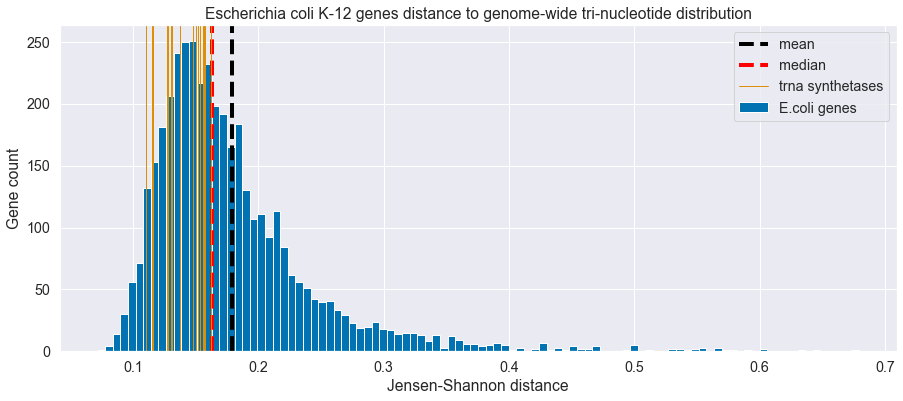

In [225]:
f, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.hist(e_coli_distances, bins=100, label='E.coli genes');

mean = np.mean(e_coli_distances)
ax.axvline(mean, color='black', label='mean', linewidth=4, linestyle='--');

median = np.median(e_coli_distances)
ax.axvline(median, color='red', label='median', linewidth=4, linestyle='--');

protein_id_distances = []
over_the_mean = []
for i, protein_id in enumerate(top_trna_proteins):
    label = 'trna synthetases' if i == 0 else None
    distance = e_coli_genes_df_ix.loc[protein_id]['distance']
    ax.axvline(distance, color=palette[1], linewidth=1, label=label);
    
    protein_id_distances.append((protein_id, distance))
    
    if distance > mean:
        over_the_mean.append(protein_id)

ax.legend();
ax.set_title('Escherichia coli K-12 genes distance to genome-wide tri-nucleotide distribution');
ax.set_xlabel('Jensen-Shannon distance');
ax.set_ylabel('Gene count');

In [259]:
max_n_elements = trna_synth_df['n_elements'].max()

for i, tigr_id in enumerate(trna_synth_df.index):
    row = trna_synth_df.loc[tigr_id]
    description = row['description']
    query = row['query']
    rank = row['rank']
    dct = compute_phylum_evidence_count(complete_genome_df, tigr_id, 'tigr', 'left', print_negative=False)
    n_elements = np.sum([v for v in dct.values()])
    dct_groups = {
        'Substantial or better': 0,
        'Weak': 0,
        'Negative': 0
    }
    for k, v in dct.items():
        if k in ('Substantial', 'Strong', 'Very Strong', 'Decisive'):
            dct_groups['Substantial or better'] += v
        else:
            dct_groups[k] += v
    
    r = sorted([(k, v) for k, v in dct_groups.items()], key=lambda t: t[1], reverse=True)
    print(
        i+1,
        tigr_id, 
        query, 
        description, 
        f'present in {n_elements} phylum',  
        f'(rank {rank:,} / {len(overall_tigr):,})',
    )
    for k, v in r:
        print('\t', k, v)
    print()

1 TIGR00392 ileS isoleucine--tRNA ligase present in 40 phylum (rank 3 / 4,266)
	 Substantial or better 31
	 Weak 9
	 Negative 0

2 TIGR00398 metG methionine--tRNA ligase present in 40 phylum (rank 4 / 4,266)
	 Substantial or better 31
	 Weak 9
	 Negative 0

3 TIGR00422 valS valine--tRNA ligase present in 40 phylum (rank 5 / 4,266)
	 Substantial or better 30
	 Weak 10
	 Negative 0

4 TIGR00344 alaS alanine--tRNA ligase present in 40 phylum (rank 7 / 4,266)
	 Substantial or better 31
	 Weak 9
	 Negative 0

5 TIGR00456 argS arginine--tRNA ligase present in 40 phylum (rank 10 / 4,266)
	 Substantial or better 32
	 Weak 8
	 Negative 0

6 TIGR00418 thrS threonine--tRNA ligase present in 40 phylum (rank 11 / 4,266)
	 Substantial or better 30
	 Weak 10
	 Negative 0

7 TIGR00435 cysS cysteine--tRNA ligase present in 40 phylum (rank 13 / 4,266)
	 Substantial or better 30
	 Weak 10
	 Negative 0

8 TIGR00414 serS serine--tRNA ligase present in 40 phylum (rank 15 / 4,266)
	 Substantial or better 26


In [262]:
compute_phylum_evidence_count(complete_genome_df, 'TIGR00392', 'tigr', 'left', print_weak=True)

Fibrobacteres
Thermodesulfobacteria
Deferribacteres
Balneolaeota
Candidatus Melainabacteria
Candidatus Micrarchaeota
Candidatus Bipolaricaulota
Lentisphaerae
Candidatus Diapherotrites


{'Decisive': 16, 'Strong': 7, 'Weak': 9, 'Substantial': 7, 'Very Strong': 1}

In [282]:
for p in [
    'Fibrobacteres',
    'Thermodesulfobacteria',
    'Deferribacteres',
    'Balneolaeota',
    'Candidatus Melainabacteria',
    'Candidatus Micrarchaeota',
    'Candidatus Bipolaricaulota',
    'Lentisphaerae',
    'Candidatus Diapherotrites',
]:
    fibrobacteres_df = load_phylum_evidence(p, 'tigr', 'left')
    print(10**(fibrobacteres_df.loc['TIGR00392']['evidence']))

1.715543047014243
2.793101191000586
2.202936607928085
2.592544741063101
2.6687328408801254
2.222034256209381
2.230659899238819
2.5951741103583013
2.031658876571317


In [285]:
compute_assembly_evidence_count(complete_genome_df, 'TIGR00392', 'tigr', 'left', 'Fibrobacteres')

{'Negative': 1}

In [286]:
complete_genome_df[complete_genome_df['phylum'] == 'Fibrobacteres']

,taxid,species_taxid,organism_name,domain,phylum,class,order,family,genus,species,strain,assembly_level
assembly_accession,,,,,,,,,,,,
GCA_000024665.1,59374,833,Fibrobacter succinogenes subsp. succinogenes S85,Bacteria,Fibrobacteres,Fibrobacteria,Fibrobacterales,Fibrobacteraceae,Fibrobacter,Fibrobacter succinogenes,Fibrobacter succinogenes subsp. succinogenes S85,Complete Genome


In [368]:
def plot_trna_synt_distances_for_assembly(assembly_df, assembly_accession, query_ids, query_type, labels=None):
    _, ax = plt.subplots(1, 1, figsize=(15, 6))
    
    if labels is None:
        print('Warning: no labels for query ids')
    
    assembly_series = assembly_df.loc[assembly_accession]
    organism_name = assembly_series['organism_name']
    phylum = assembly_series['phylum']
    
    genes_df, distances = load_gene_dist(assembly_accession)
    genes_df = genes_df.set_index('protein_id', drop=True)
    genes_ix = genes_df.index
    
    if query_type == 'tigr':
        fam_df = load_protein_families(assembly_accession, 'tigr')
    else:
        fam_df = load_protein_families(assembly_accession, 'pfam')
    
    query_set = set(query_ids)
    query_ix = [v for v in fam_df.index if v in query_set]
    protein_ids = fam_df.loc[query_ix]['protein_id'].unique()
    print(f'{len(protein_ids):,} protein ids')
    
    ax.hist(distances, bins=100, label=f'genes ({len(genes_df):,})');

    index = -1
    for i, protein_id in enumerate(protein_ids):
        if protein_id not in genes_ix:
            continue
        else:
            index += 1
            
        if labels is not None and index < len(labels):
            label = labels[index]
        else:
            label = None
            
        distance = genes_df.loc[protein_id]['distance']
        ax.axvline(distance, color=palette[1], linewidth=1, label=label);

    mean = np.mean(distances)
    ax.axvline(mean, color='black', label='mean', linewidth=4, linestyle='--');

    ax.legend();
    ax.set_title(f'{organism_name} ({phylum})');
    ax.set_xlabel('Jensen-Shannon distance between genome-wide and per-gene tri-nucleotide distributions');
    ax.set_ylabel('Count');
    
    return ax

In [369]:
trna_synt_tigr_ids = overall_tigr[
    overall_tigr['description'].notnull() & 
    (overall_tigr['description'].str.contains('--tRNA ligase'))
].index.tolist()

21 protein ids


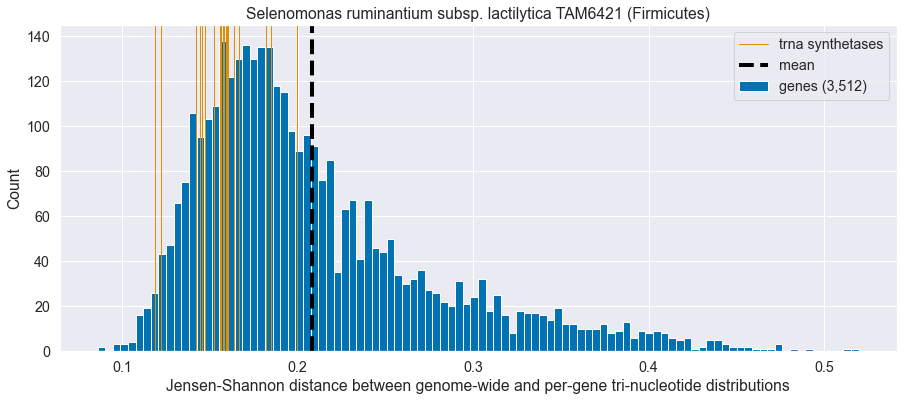

In [370]:
plot_trna_synt_distances_for_assembly(
    assembly_df, 
    assembly_accession=complete_genome_df.index[200], 
    query_ids=trna_synt_tigr_ids, 
    query_type='tigr', 
    labels=['trna synthetases'],
);

20 protein ids


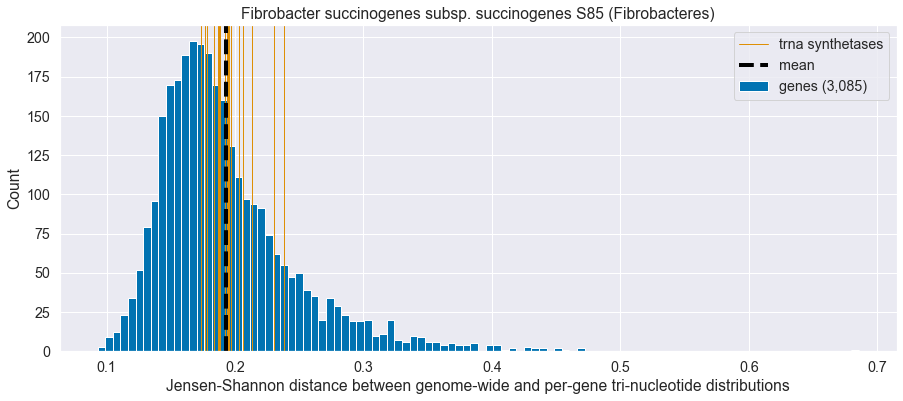

In [371]:
plot_trna_synt_distances_for_assembly(
    assembly_df, 
    assembly_accession='GCA_000024665.1', 
    query_ids=trna_synt_tigr_ids, 
    query_type='tigr', 
    labels=['trna synthetases'],
);

In [372]:
tnra_synth_proteins

array(['AIZ53946.1', 'AIZ52687.1', 'AIZ51520.1', 'AIZ53175.1',
       'AIZ51924.1', 'AIZ52494.1', 'AIZ54785.1', 'AIZ54523.1',
       'AIZ51516.1', 'AIZ51434.1', 'AIZ52331.1', 'AIZ52218.1',
       'AIZ51762.1', 'AIZ51693.1', 'AIZ54080.1', 'AIZ51515.1',
       'AIZ54492.1', 'AIZ54375.1', 'AIZ51682.1', 'AIZ54744.1',
       'AIZ51730.1', 'AIZ53363.1', 'AIZ53364.1'], dtype=object)

In [376]:
overall_pfam.loc[
    e_coli_pfam[
        e_coli_pfam['protein_id'] == 'AIZ53946.1'
    ].index
].sort_values('rank')

,id,description,log_probability,log_probability_random,n_elements,evidence,evidence_strength,rank
query,,,,,,,,
tRNA_anti-codon,PF01336,OB-fold nucleic acid binding domain,-5.996854,-8.223356,68,0.966958,Substantial,5
tRNA-synt_2,PF00152,tRNA synthetases class II (D; K and N),-5.467435,-6.964909,68,0.650345,Substantial,17
tRNA-synt_2d,PF01409,tRNA synthetases class II core domain (F),-4.196600,-5.198127,68,0.434958,Weak,43


In [393]:
protein_id = 'AIZ52331.1'

In [394]:
overall_tigr.loc[
    tigr_fam[tigr_fam['protein_id'] == protein_id].index
]

,query,description,log_probability,log_probability_random,n_elements,evidence,evidence_strength,rank
query,,,,,,,,
TIGR00442,hisS,histidine--tRNA ligase,-2.683305,-3.26301,68,0.251762,Weak,19


In [391]:
overall_pfam.loc[
    e_coli_pfam[
        e_coli_pfam['protein_id'] == protein_id
    ].index
].sort_values('rank')

,id,description,log_probability,log_probability_random,n_elements,evidence,evidence_strength,rank
query,,,,,,,,
tRNA-synt_2b,PF00587,tRNA synthetase class II core domain (G; H; P;...,-8.065469,-10.291771,68,0.966871,Substantial,6
HGTP_anticodon,PF03129,Anticodon binding domain,-8.743684,-10.242978,68,0.651135,Substantial,16
HGTP_anticodon,PF03129,Anticodon binding domain,-8.743684,-10.242978,68,0.651135,Substantial,16
tRNA_SAD,PF07973,Threonyl and Alanyl tRNA synthetase second add...,-3.801221,-4.919086,68,0.485483,Weak,35
TGS,PF02824,TGS domain,-2.235653,-2.503720,67,0.116420,Weak,272


In [406]:
overall_tigr.loc[
    tigr_fam[tigr_fam['protein_id'].isin(
        e_coli_pfam.loc[[
            'tRNA-synt_1g',
        ]]['protein_id'].values
    )].index
].sort_values('rank')

,query,description,log_probability,log_probability_random,n_elements,evidence,evidence_strength,rank
query,,,,,,,,
TIGR00392,ileS,isoleucine--tRNA ligase,-2.274888,-3.233450,68,0.416298,Weak,3
TIGR00398,metG,methionine--tRNA ligase,-2.393383,-3.233288,68,0.364766,Weak,4
TIGR00422,valS,valine--tRNA ligase,-2.346624,-3.179051,68,0.361519,Weak,5
TIGR00435,cysS,cysteine--tRNA ligase,-2.774702,-3.451021,68,0.293722,Weak,13
TIGR00396,leuS_bact,leucine--tRNA ligase,-1.916679,-2.293328,64,0.163577,Weak,25
TIGR00399,metG_C_term,methionine--tRNA ligase; beta subunit,-0.945531,-0.974718,53,0.012676,Weak,582


In [407]:
overall_tigr.loc[
    tigr_fam[tigr_fam['protein_id'].isin(
        e_coli_pfam.loc[[
            'tRNA-synt_1c',
        ]]['protein_id'].values
    )].index
].sort_values('rank')

,query,description,log_probability,log_probability_random,n_elements,evidence,evidence_strength,rank
query,,,,,,,,
TIGR00464,gltX_bact,glutamate--tRNA ligase,-1.853630,-2.12551,63,0.118076,Weak,43
TIGR00440,glnS,glutamine--tRNA ligase,-0.530205,-0.57392,36,0.018985,Weak,369
TIGR03838,queuosine_YadB,glutamyl-queuosine tRNA(Asp) synthetase,-0.153050,-0.15370,14,0.000282,Weak,2495


In [420]:
overall_pfam.loc[
    e_coli_pfam[
        e_coli_pfam['protein_id'] == tigr_fam.loc['TIGR00464']['protein_id']
    ].index
].sort_values('rank')

,id,description,log_probability,log_probability_random,n_elements,evidence,evidence_strength,rank
query,,,,,,,,
tRNA-synt_1c,PF00749,tRNA synthetases class I (E and Q); catalytic ...,-3.004497,-3.925712,68,0.400079,Weak,50


In [411]:
overall_pfam.loc[
    e_coli_pfam[
        e_coli_pfam['protein_id'] == tigr_fam.loc['TIGR00392']['protein_id']
    ].index
].sort_values('rank')

,id,description,log_probability,log_probability_random,n_elements,evidence,evidence_strength,rank
query,,,,,,,,
tRNA-synt_1g,PF09334,tRNA synthetases class I (M),-8.455370,-11.917688,68,1.503665,Very Strong,2
tRNA-synt_1,PF00133,tRNA synthetases class I (I; L; M and V),-7.481862,-10.718066,68,1.405466,Strong,3
Anticodon_1,PF08264,Anticodon-binding domain of tRNA ligase,-5.654588,-7.960641,68,1.001506,Strong,4
tRNA-synt_1_2,PF13603,Leucyl-tRNA synthetase; Domain 2,-3.297744,-4.354387,68,0.458894,Weak,36
tRNA-synt_1e,PF01406,tRNA synthetases class I (C) catalytic domain,-5.163488,-6.174149,68,0.438925,Weak,40
zf-FPG_IleRS,PF06827,Zinc finger found in FPG and IleRS,-1.539546,-1.679731,64,0.060881,Weak,533


## tRNA synt stats

In [438]:
trna_synt_stats = pd.read_csv(os.path.join(os.getcwd(), 'data/trna_synt_stats.csv'), index_col='assembly_accession')
trna_synt_stats.head()

,organism_name,phylum,n_trna_synt_genes,distance_mean,distance_std
assembly_accession,,,,,
GCA_000010525.1,Azorhizobium caulinodans ORS 571,Proteobacteria,20,0.132344,0.013906
GCA_000218545.1,Cellulomonas gilvus ATCC 13127,Actinobacteria,18,0.126792,0.016198
GCA_000020965.1,Dictyoglomus thermophilum H-6-12,Dictyoglomi,21,0.155986,0.017800
GCA_000012885.1,Pelobacter carbinolicus DSM 2380,Proteobacteria,22,0.122260,0.019983
GCA_000016585.1,Shewanella putrefaciens CN-32,Proteobacteria,22,0.126295,0.012696


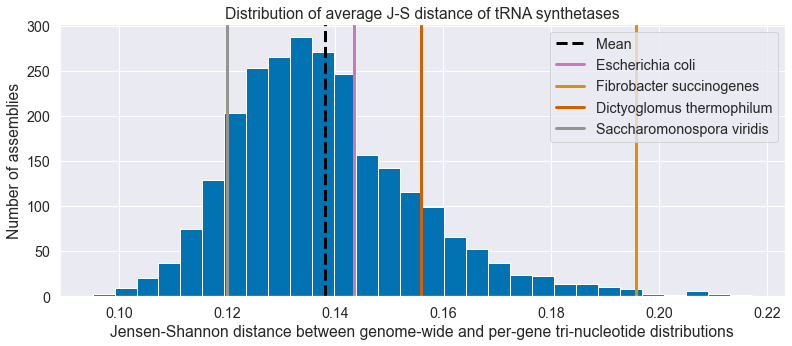

In [473]:
_, ax = plt.subplots(1, 1, figsize=(13, 5))
ax.hist(trna_synt_stats['distance_mean'].values, bins=30);

ax.axvline(
    np.mean(trna_synt_stats['distance_mean'].values), 
    color='black',
    linestyle='--',
    linewidth=3,
    label='Mean',
);
ax.axvline(
    trna_synt_stats.loc[e_coli_assembly]['distance_mean'], 
    color=palette[4], 
    linewidth=3,
    label='Escherichia coli');
ax.axvline(
    trna_synt_stats.loc['GCA_000024665.1']['distance_mean'], 
    color=palette[1], 
    linewidth=3,
    label='Fibrobacter succinogenes',
);
ax.axvline(
    trna_synt_stats.loc[dictyoglomus_thermophilum_assembly]['distance_mean'], 
    color=palette[3], 
    linewidth=3,
    label='Dictyoglomus thermophilum'
);
ax.axvline(
    trna_synt_stats.loc['GCA_000023865.1']['distance_mean'], 
    color=palette[7], 
    linewidth=3,
    label='Saccharomonospora viridis',
);

ax.legend();

ax.set_title('Distribution of average J-S distance of tRNA synthetases');
ax.set_xlabel('Jensen-Shannon distance between genome-wide and per-gene tri-nucleotide distributions');
ax.set_ylabel('Number of assemblies');

In [477]:
trna_synt_stats.sort_values('distance_mean', ascending=False).head(20)

,organism_name,phylum,n_trna_synt_genes,distance_mean,distance_std
assembly_accession,,,,,
GCA_001552015.1,Candidatus Nanopusillus acidilobi,Nanoarchaeota,12,0.217169,0.027288
GCA_000178975.2,Granulicella tundricola MP5ACTX9,Acidobacteria,20,0.212902,0.037358
GCA_000214415.1,Methanotorris igneus Kol 5,Euryarchaeota,18,0.211689,0.018442
GCA_000739065.1,Methanocaldococcus bathoardescens,Euryarchaeota,18,0.207367,0.020346
GCA_003351865.1,Methanofervidicoccus sp. A16,Euryarchaeota,19,0.207209,0.021271
GCA_000023985.1,Methanocaldococcus fervens AG86,Euryarchaeota,18,0.206128,0.020034
GCA_000091665.1,Methanocaldococcus jannaschii DSM 2661,Euryarchaeota,18,0.205827,0.017017
GCA_000025525.1,Methanocaldococcus sp. FS406-22,Euryarchaeota,18,0.205673,0.020669
GCA_002310495.1,Nibricoccus aquaticus,Verrucomicrobia,20,0.205128,0.029110
